## Kerr from exact schwarzschild solution
p, M, e constants

In [1]:
project_path = "../../../../../"

"../../../../../"

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
import StatsBase: sample
# gr(); # specify backend for plotting

include(project_path * "src/utils/imports.jl")
import_project_utils(project_path);

  Activating project at `~/Escritorio/TFM/repo`


seeds and data paths

In [3]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "kerr_from_newton/"
model_name = "kerr_from_newton/"

output_directory = project_path * "data/output/case_1/" * test_name
output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"
list_directories = (output_directory, output_directory* "models/", output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)

Define neural network model

In [4]:
# function normalize_angle(angle)::Float64
#     """
#     Normalize angle between [-pi, pi]
#     """
#     normalize_angle = mod(angle + pi, 2*pi) - pi
#     return normalize_angle < -pi ? normalize_angle + 2*pi : normalize_angle
# end

# function normalize_chi(chi::Float64)::Float64
#     """
#     Normalize for mean 0 and std 1 -> hat{x} = (x - mean(x)) / std(x)
#     """
#     norm_chi = (normalize_angle(chi)) / pi
#     return norm_chi 
# end 
# x =  4*pi
# normalize_chi(x), normalize_angle(x)

In [5]:
# a_space = Float64.([1e-5, 1e-3, 0.01, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0])
# a_mean = mean(a_space)
# a_std = std(a_space)

# function z_normalization_spin(a; a_mean::Float64=a_mean, a_std::Float64=a_std)::Float64
#     return (a-a_mean) / a_std
# end

# z_normalization_spin(0)

In [6]:

# function process_chain(chain:: Chain; initialize_as_zero::Bool = true)
#     """
#     Extract parameters from chain. By default, initialize them to zero
#     """

#     NN_params, re = Flux.destructure(chain)

#     if initialize_as_zero
#         println("Initializating weights as zero.")
#         NN_params::Vector{Float64} = NN_params / 100
#     end

#     NN(u, NN_params) = re(NN_params)(u)

#     return NN, NN_params, chain, re
# end


# function nn_model_case1_arch1_modified(number_of_neurons_in_hidden_layer::Int64, activation_function; type::String = "standard")
#     """
#     Define multiple configurations of architecture of type 1
#     # softmodulusQ, leakyrelu, relu, cos, tanh, abs, sigmoid
#     """

#     if type == "standard"
#         chain = Chain(
#             # x = [χ, ϕ, a, p, M, e]
#             # x -> Float32.([normalize_chi(x[1]), x[3], x[3]^2, x[3]^3, 1/x[3], 1/x[3]^2]),
#             # Dense(6, Int(number_of_neurons_in_hidden_layer/2), activation_function),
#             x -> Float32.([x[1], z_normalization_spin(x[3])]),
#             x -> Float32.([x[1], x[1]*x[2], x[2],  x[2]^2, x[2]^3]),
#             Dense(5, Int(number_of_neurons_in_hidden_layer/2), activation_function),    
#             Dense(Int(number_of_neurons_in_hidden_layer/2), number_of_neurons_in_hidden_layer, activation_function),
#             Dense(number_of_neurons_in_hidden_layer, number_of_neurons_in_hidden_layer, activation_function),
#             # Dense(number_of_neurons_in_hidden_layer, number_of_neurons_in_hidden_layer, activation_function),
#             # Dropout(0.8),
#             Dense(number_of_neurons_in_hidden_layer, 2)
#         )
#     end

#     NN, NN_params, chain, re = process_chain(chain)

#     return NN, NN_params, chain, re
# end

# NN, NN_params, chain, re = nn_model_case1_arch1_modified(64, relu);
# # NO: tanh

In [7]:
NN, NN_params, chain, re = nn_model_emr_kerr_from_newton(64, relu);

Initializating weights as zero.


Define dataset

In [8]:
datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi/2); 
ϕ₀ = Float64(0.0);
p_space = [20.0]
M=Float64(1.0);
e = Float64(0.5)
tspan_train = (0, 6.0e3)
a_space = Float64.([1e-5, 1e-3, 0.01, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0])

train_info = [];
for a in a_space 
    for p in p_space
        train_info_i = get_pinn_EMR_newton(χ₀, ϕ₀, p, M, e, a, tspan_train, datasize, dt);
        true_info = get_true_solution_EMR_kerr(train_info_i["u0"], train_info_i["model_params"], M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
        push!(train_info, merge(train_info_i, true_info))
    end
end

# TEST waveform parameters

p = 20.0
factor = 1
datasize = datasize * factor
tspan_test = (tspan_train[1], tspan_train[2]*factor)
# a_space = Float64.([1e-5, 1e-3, 0.2, 0.35, 0.75, 0.85])

test_info = [];
for a in a_space
    test_info_i = get_pinn_EMR_newton(χ₀, ϕ₀, p, M, e, a, tspan_test, datasize, dt);
    true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
    push!(test_info, merge(test_info_i, true_info))
end

# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);

Processing datasets
Creating test dataset 
Creating train dataset 


Let's see train waveform differences

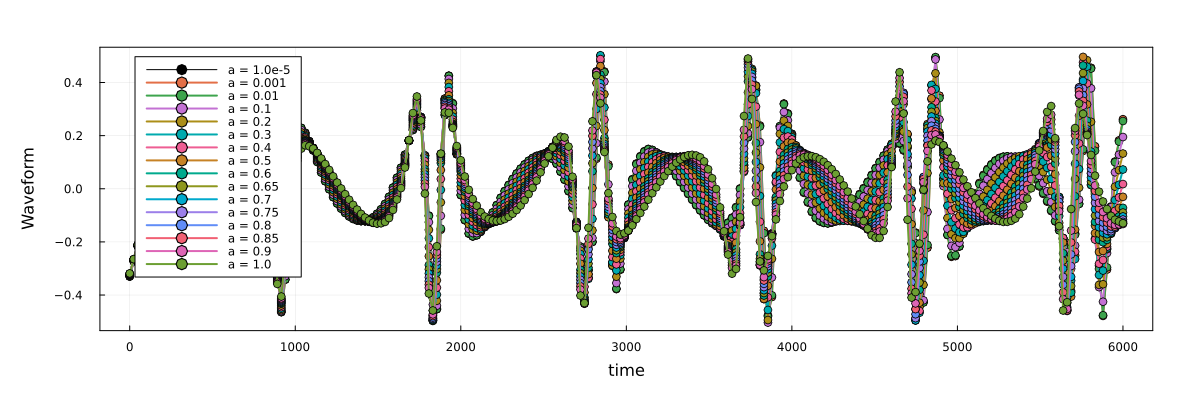

In [9]:
example = processed_data["train"][1]
waveforms_plot = plot(
    example["tsteps"],
    example["true_waveform"],
    label= "a = "*string(example["model_params"][4]),
    size=(1200,400),
    margin=10Plots.mm,
    framestyle=:box,
    ylabel="Waveform",
    xlabel="time",
    markersize=4,
    marker=:o,
    color=:black,
)

m = length(processed_data["train"])
for index in 2:m 
    example = processed_data["train"][index]
    plot!(
        waveforms_plot,
        example["tsteps"],
        example["true_waveform"],
        label= "a = " * string(example["model_params"][4]),
        marker=:o,
        # markersize=4,
        linewidth=2,
    )
end
waveforms_plot

Let's see the approximation of our PINN model before training

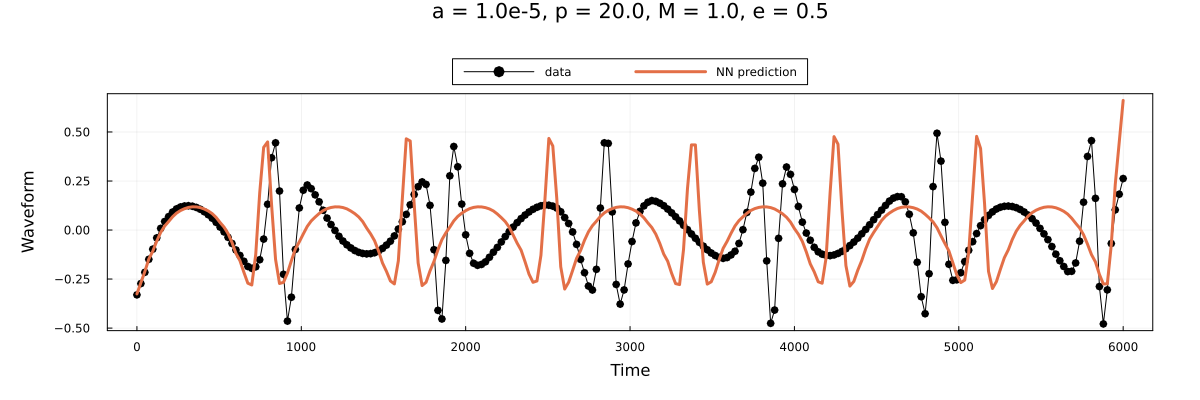

In [10]:
example = processed_data["train"][1]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

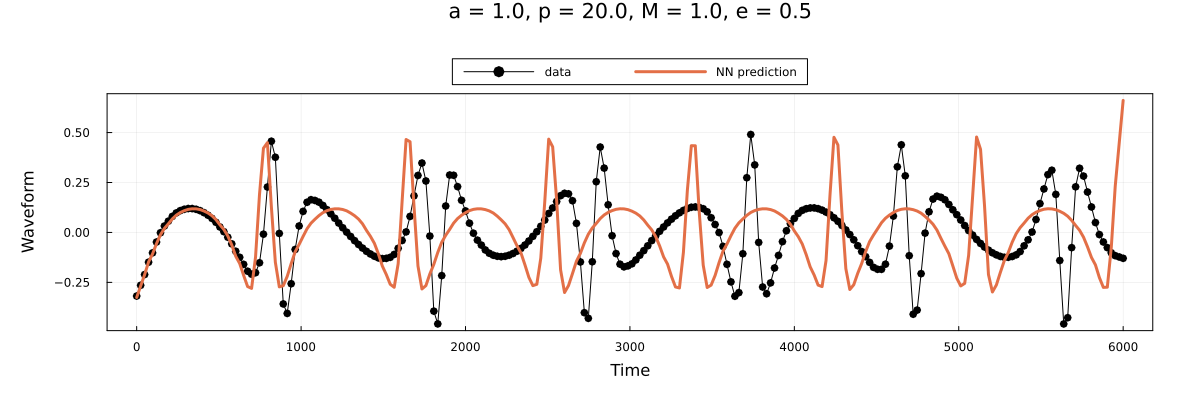

In [11]:
example = processed_data["train"][end]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

Train our PINN

In [ ]:

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
plot_list = []
weights = []

show_plots = true

callback_EMR(θ::Vector{Float64}, train_loss::Float64, agregated_metrics::Dict{String, Float64}, train_loss_information::Dict, test_loss_information::Dict; show_plots::Bool = show_plots, save_plots_gif::Bool=save_plots_gif) = begin

    # add losses
    push!(train_losses, agregated_metrics["train_loss"])
    push!(test_losses, agregated_metrics["test_loss"])
    push!(train_metrics, agregated_metrics["train_metric"])
    push!(test_metrics, agregated_metrics["test_metric"])
    push!(weights, θ)

    if show_plots
        # train waveform
        title = create_waveform_title(train_loss_information["model_params"][1], train_loss_information["model_params"][2], train_loss_information["model_params"][3], train_loss_information["model_params"][4])
        plt1 = train_plot(train_loss_information["tsteps"], train_loss_information["true_waveform"], train_loss_information["pred_waveform"], title=title)

        # test waveform
        title = create_waveform_title(test_loss_information["model_params"][1], test_loss_information["model_params"][2], test_loss_information["model_params"][3], test_loss_information["model_params"][4])
        plt2 = test_plot(train_loss_information["tsteps"], test_loss_information["tsteps"], test_loss_information["true_waveform"], test_loss_information["pred_waveform"], title=title)

        l = @layout [a; b]
        plt = plot(plt1, plt2, layout=l)
        if save_plots_gif
            push!(plot_list, plt)
        end
    end

    return false
end

loss_f(p) = loss_function_case1(p, processed_data=processed_data, batch_size=14, loss_function_name="mae", subset=250)

adtype = Optimization.AutoZygote()
optfunct = Optimization.OptimizationFunction((x, p) -> loss_f(x), adtype)
optprob = Optimization.OptimizationProblem(optfunct, NN_params)

res = Optimization.solve(
    optprob,
    Flux.Optimise.ADAM(0.0005),
    callback=callback_EMR,
    maxiters=200
);

# Flux.Optimise.ADAM(0.00000001), # [1.0, 10.0, 15.0, 5.0] and p = 100.0 and [0, 6.3] and batch_size = 5-7
# BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), # -> 1 waveform overfitting

Loss function

In [ ]:
plot_losses = plot(train_losses, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="Loss Function")
plot!(plot_losses, test_losses, label="test", marker=:o, linewidth=2)

plot_mse = plot(train_metrics, label="train", xlabel="Epochs", ylabel="MSE", framestyle=:box, marker=:o, linewidth=2, title="Metric")
plot!(plot_mse, test_metrics, label="test", marker=:o, linewidth=2)

plot_metrics = plot(plot_losses, plot_mse, layout=(1,2), size=(1200,400), margin=10Plots.mm)

See last epoch predictions

In [ ]:
best_test_epoch = findmin(test_losses)[2]
print("Best epoch: ", best_test_epoch)
prediction_plot = plot(plot_list[best_test_epoch])

In [ ]:
savefig(prediction_plot, output_dir*"/prediction_plot.png")
savefig(plot_metrics, output_dir*"/plot_metrics.png")

"/home/rubenbalbastre/Escritorio/TFM/repo/src/processing/experiments/kerr/case_1/prediction_plot.png"

Save model weights

In [ ]:
# save flux chain models as bson files. To do so, we must save chain model with its parameters
NN_params = weights[best_test_epoch];
Flux.loadparams!(chain, Flux.params(re(NN_params)))
@save solutions_dir*"model_chiphi.bson" chain